## Import the necessary libraries

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.semi_supervised import LabelSpreading
from matplotlib import pyplot as plt

## Load the dataset

In [ ]:
# Load datasets
data_path = '/content/drive/MyDrive/Colab-Notebooks/Data-Science/baseline/dataset/'
transactions_train = pd.read_csv(data_path + 'transactions_train.csv')
train_target = pd.read_csv(data_path + 'train_target.csv')
transactions_test = pd.read_csv(data_path + 'transactions_test.csv')
test_id = pd.read_csv(data_path + 'test.csv')

In [ ]:
test_id.head()

,client_id
0,28571
1,27046
2,13240
3,19974
4,10505


Let's look at data

In [ ]:
transactions_train.head()

,client_id,trans_date,small_group,amount_rur
0,33172,6,4,71.463
1,33172,6,35,45.017
2,33172,8,11,13.887
3,33172,9,11,15.983
4,33172,10,11,21.341


* **client_id** is a unique identifier of the client

* **trans_date** is the date of the transaction

* **small_group** - purchase category

* **amount_rur** is the transaction amount


In [ ]:
train_target.head(5)

,client_id,bins
0,24662,2
1,1046,0
2,34089,2
3,34848,1
4,47076,3


* **client_id** is the unique identifier of the client, corresponding to the
client_id field of the transactions
* **bins** - the target variable to predict, this is the customer's age category

## Calculate the simplest aggregation signs for each client

Here, we aggregate transaction data to create summary statistics for each client. This involves calculating the **sum, mean, standard deviation, minimum, and maximum** of transaction amounts for each client.

In [ ]:
# Calculate aggregation features for each client
agg_features_train = transactions_train.groupby('client_id')['amount_rur'].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
agg_features_test = transactions_test.groupby('client_id')['amount_rur'].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()

## Calculate the number of transactions for each category for each client

We count the number of transactions each client has in each purchase category (small_group). This helps in understanding the spending patterns across different categories.


In [ ]:
# Calculate transaction counts for each category for each client
counter_df_train = transactions_train.groupby(['client_id', 'small_group'])['amount_rur'].count()
cat_counts_train = counter_df_train.reset_index().pivot(index='client_id', columns='small_group', values='amount_rur').fillna(0)
cat_counts_train.columns = ['small_group_' + str(i) for i in cat_counts_train.columns]

counter_df_test = transactions_test.groupby(['client_id', 'small_group'])['amount_rur'].count()
cat_counts_test = counter_df_test.reset_index().pivot(index='client_id', columns='small_group', values='amount_rur').fillna(0)
cat_counts_test.columns = ['small_group_' + str(i) for i in cat_counts_test.columns]

## Merge all the files into a single dataframe
We merge the aggregated features with the transaction counts to create a single DataFrame for training and testing.

In [ ]:
# Merge train data
train = pd.merge(train_target, agg_features_train, on='client_id')
train = pd.merge(train, cat_counts_train.reset_index(), on='client_id')

# Merge test data
test = pd.merge(test_id, agg_features_test, on='client_id')
test = pd.merge(test, cat_counts_test.reset_index(), on='client_id')

 The test did not have some categories of expenses, so in order to ensure consistency, we need to combine the feature space of train and test

In [ ]:
common_features = list(set(train.columns).intersection(set(test.columns)))
y_train = train['bins']
X_train = train[common_features]
X_test = test[common_features]

## Normalize the features

We standardize the features so that they have a mean of 0 and a standard deviation of 1. This helps in improving the performance of clustering algorithms.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.drop(columns=['client_id']))
X_test_scaled = scaler.transform(X_test.drop(columns=['client_id']))

## Semi-supervised clustering using Label Spreading with batch processing

In [ ]:
# Semi-supervised clustering using Label Spreading with batch processing
batch_size = 1000
num_batches = len(X_train_scaled) // batch_size

label_prop_model = LabelSpreading(kernel='rbf', gamma=0.25)


for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(X_train_scaled))
    batch_X = X_train_scaled[start_idx:end_idx]
    batch_y = train_target['bins'].iloc[start_idx:end_idx]
    label_prop_model.fit(batch_X, batch_y)

In [ ]:
test_clusters = label_prop_model.predict(X_test_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


In [ ]:
test_clusters

array([2, 3, 3, ..., 2, 2, 1])

## Plotting the result

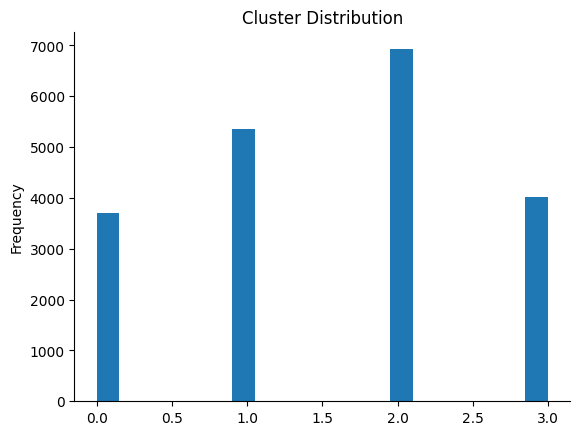

In [ ]:
# Prepare submission file
submission = pd.DataFrame({'client_id': test['client_id'], 'cluster': test_clusters})
submission['cluster'].plot(kind='hist', bins=20, title='Cluster Distribution')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

## predicting the age group with Flame AutoML

In [ ]:
pip install flaml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 6.1 MB/s eta 0:00:00


X_train shape: (30000, 193)
y_train shape: (30000,)
X_test shape: (20000, 193)
combined_X shape: (50000, 193)
combined_y shape: (50000,)
combined_X indices: Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       19990, 19991, 19992, 19993, 19994, 19995, 19996, 19997, 19998, 19999],
      dtype='int64', length=50000)
combined_y indices: Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       19990, 19991, 19992, 19993, 19994, 19995, 19996, 19997, 19998, 19999],
      dtype='int64', length=50000)


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_label_propagation.py:318: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


[flaml.automl.logger: 06-27 09:18:49] {1680} INFO - task = classification
[flaml.automl.logger: 06-27 09:18:49] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 06-27 09:18:49] {1789} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 06-27 09:18:49] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 06-27 09:18:49] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-27 09:18:50] {2345} INFO - Estimated sufficient time budget=2171s. Estimated necessary time budget=50s.
[flaml.automl.logger: 06-27 09:18:50] {2392} INFO -  at 1.5s,	estimator lgbm's best error=0.5243,	best estimator lgbm's best error=0.5243
[flaml.automl.logger: 06-27 09:18:50] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-27 09:18:50] {2392} INFO -  at 1.7s,	estimator lgbm's best error=0.5243,	best estimator lgbm's best error=0.5243
[flaml.automl.logger: 06-27 0

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


[flaml.automl.logger: 06-27 09:21:08] {2392} INFO -  at 139.9s,	estimator lrl1's best error=0.6774,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:21:08] {2219} INFO - iteration 83, current learner xgboost


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-27 09:21:13] {2392} INFO -  at 144.5s,	estimator xgboost's best error=0.4441,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:21:13] {2219} INFO - iteration 84, current learner lrl1
[flaml.automl.logger: 06-27 09:21:36] {2392} INFO -  at 168.3s,	estimator lrl1's best error=0.6774,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:21:36] {2219} INFO - iteration 85, current learner xgb_limitdepth


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-27 09:21:37] {2392} INFO -  at 169.1s,	estimator xgb_limitdepth's best error=0.4581,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:21:37] {2219} INFO - iteration 86, current learner xgb_limitdepth
[flaml.automl.logger: 06-27 09:21:38] {2392} INFO -  at 169.5s,	estimator xgb_limitdepth's best error=0.4581,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:21:38] {2219} INFO - iteration 87, current learner xgb_limitdepth
[flaml.automl.logger: 06-27 09:21:38] {2392} INFO -  at 170.0s,	estimator xgb_limitdepth's best error=0.4581,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:21:38] {2219} INFO - iteration 88, current learner xgb_limitdepth
[flaml.automl.logger: 06-27 09:21:40] {2392} INFO -  at 171.8s,	estimator xgb_limitdepth's best error=0.4551,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:21:40] {2219} INFO - iteration 89, current learner xgboost
[flaml.automl.logge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-27 09:22:08] {2392} INFO -  at 199.8s,	estimator xgboost's best error=0.4441,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:22:08] {2219} INFO - iteration 93, current learner lrl1
[flaml.automl.logger: 06-27 09:22:30] {2392} INFO -  at 222.2s,	estimator lrl1's best error=0.6774,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:22:30] {2219} INFO - iteration 94, current learner xgb_limitdepth


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-27 09:22:31] {2392} INFO -  at 223.2s,	estimator xgb_limitdepth's best error=0.4551,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:22:31] {2219} INFO - iteration 95, current learner xgb_limitdepth
[flaml.automl.logger: 06-27 09:22:35] {2392} INFO -  at 226.7s,	estimator xgb_limitdepth's best error=0.4551,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:22:35] {2219} INFO - iteration 96, current learner lgbm
[flaml.automl.logger: 06-27 09:22:41] {2392} INFO -  at 233.2s,	estimator lgbm's best error=0.4421,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:22:41] {2219} INFO - iteration 97, current learner lrl1
[flaml.automl.logger: 06-27 09:23:05] {2392} INFO -  at 256.4s,	estimator lrl1's best error=0.6774,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:23:05] {2219} INFO - iteration 98, current learner xgboost


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-27 09:23:15] {2392} INFO -  at 266.7s,	estimator xgboost's best error=0.4441,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:23:15] {2219} INFO - iteration 99, current learner xgboost
[flaml.automl.logger: 06-27 09:23:20] {2392} INFO -  at 272.3s,	estimator xgboost's best error=0.4441,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:23:20] {2219} INFO - iteration 100, current learner rf
[flaml.automl.logger: 06-27 09:23:21] {2392} INFO -  at 272.6s,	estimator rf's best error=0.4937,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:23:21] {2219} INFO - iteration 101, current learner rf
[flaml.automl.logger: 06-27 09:23:21] {2392} INFO -  at 272.9s,	estimator rf's best error=0.4937,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:23:21] {2219} INFO - iteration 102, current learner xgb_limitdepth
[flaml.automl.logger: 06-27 09:23:22] {2392} INFO -  at 273.4s,	estimator xgb_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-27 09:23:53] {2392} INFO -  at 305.0s,	estimator rf's best error=0.4920,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:23:53] {2219} INFO - iteration 110, current learner lrl1
[flaml.automl.logger: 06-27 09:24:16] {2392} INFO -  at 328.1s,	estimator lrl1's best error=0.6774,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:24:16] {2219} INFO - iteration 111, current learner extra_tree


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-27 09:24:17] {2392} INFO -  at 328.7s,	estimator extra_tree's best error=0.5013,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:24:17] {2219} INFO - iteration 112, current learner lgbm
[flaml.automl.logger: 06-27 09:24:18] {2392} INFO -  at 329.5s,	estimator lgbm's best error=0.4421,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:24:18] {2219} INFO - iteration 113, current learner extra_tree
[flaml.automl.logger: 06-27 09:24:18] {2392} INFO -  at 329.9s,	estimator extra_tree's best error=0.5013,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:24:18] {2219} INFO - iteration 114, current learner extra_tree
[flaml.automl.logger: 06-27 09:24:19] {2392} INFO -  at 330.5s,	estimator extra_tree's best error=0.5013,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:24:19] {2219} INFO - iteration 115, current learner lrl1
[flaml.automl.logger: 06-27 09:24:41] {2392} INFO -  at 35

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-27 09:24:42] {2392} INFO -  at 353.7s,	estimator xgboost's best error=0.4441,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:24:42] {2219} INFO - iteration 117, current learner rf
[flaml.automl.logger: 06-27 09:24:42] {2392} INFO -  at 354.0s,	estimator rf's best error=0.4920,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:24:42] {2219} INFO - iteration 118, current learner xgb_limitdepth
[flaml.automl.logger: 06-27 09:24:49] {2392} INFO -  at 360.6s,	estimator xgb_limitdepth's best error=0.4551,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:24:49] {2219} INFO - iteration 119, current learner extra_tree
[flaml.automl.logger: 06-27 09:24:49] {2392} INFO -  at 361.0s,	estimator extra_tree's best error=0.5013,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:24:49] {2219} INFO - iteration 120, current learner lgbm
[flaml.automl.logger: 06-27 09:24:52] {2392} INFO -  at 3

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-27 09:26:17] {2392} INFO -  at 448.9s,	estimator extra_tree's best error=0.4973,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:26:17] {2219} INFO - iteration 139, current learner lgbm
[flaml.automl.logger: 06-27 09:26:20] {2392} INFO -  at 451.4s,	estimator lgbm's best error=0.4421,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:26:20] {2219} INFO - iteration 140, current learner xgb_limitdepth
[flaml.automl.logger: 06-27 09:26:25] {2392} INFO -  at 457.2s,	estimator xgb_limitdepth's best error=0.4457,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:26:25] {2219} INFO - iteration 141, current learner rf
[flaml.automl.logger: 06-27 09:26:26] {2392} INFO -  at 457.5s,	estimator rf's best error=0.4920,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:26:26] {2219} INFO - iteration 142, current learner xgb_limitdepth
[flaml.automl.logger: 06-27 09:26:28] {2392} INFO -  at 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-27 09:28:21] {2392} INFO -  at 572.5s,	estimator extra_tree's best error=0.4920,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:28:21] {2219} INFO - iteration 159, current learner rf
[flaml.automl.logger: 06-27 09:28:21] {2392} INFO -  at 573.0s,	estimator rf's best error=0.4907,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:28:21] {2219} INFO - iteration 160, current learner xgboost
[flaml.automl.logger: 06-27 09:28:22] {2392} INFO -  at 574.1s,	estimator xgboost's best error=0.4441,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:28:22] {2219} INFO - iteration 161, current learner extra_tree
[flaml.automl.logger: 06-27 09:28:23] {2392} INFO -  at 575.0s,	estimator extra_tree's best error=0.4900,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:28:23] {2219} INFO - iteration 162, current learner rf
[flaml.automl.logger: 06-27 09:28:23] {2392} INFO -  at 575.3s,	estima

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-27 09:28:47] {2392} INFO -  at 598.6s,	estimator extra_tree's best error=0.4900,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:28:47] {2219} INFO - iteration 166, current learner rf
[flaml.automl.logger: 06-27 09:28:47] {2392} INFO -  at 598.9s,	estimator rf's best error=0.4890,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:28:47] {2219} INFO - iteration 167, current learner rf
[flaml.automl.logger: 06-27 09:28:48] {2392} INFO -  at 599.4s,	estimator rf's best error=0.4890,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:28:48] {2219} INFO - iteration 168, current learner rf
[flaml.automl.logger: 06-27 09:28:48] {2392} INFO -  at 599.6s,	estimator rf's best error=0.4890,	best estimator lgbm's best error=0.4421
[flaml.automl.logger: 06-27 09:28:48] {2219} INFO - iteration 169, current learner rf
[flaml.automl.logger: 06-27 09:28:48] {2392} INFO -  at 600.1s,	estimator rf's best error=0.4830

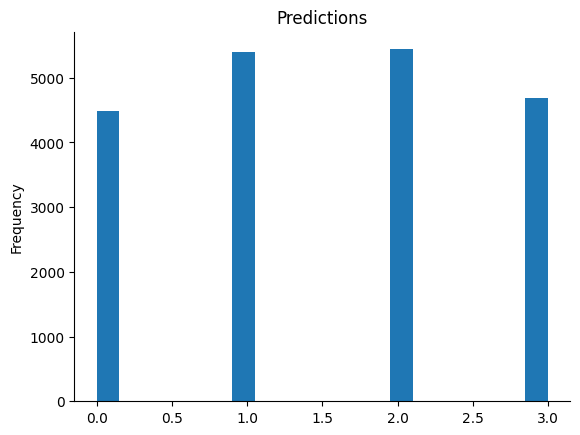

In [ ]:
import numpy as np
import xgboost as xgb
from matplotlib import pyplot as plt
from flaml import AutoML
from sklearn.metrics import accuracy_score

# Debug: Print shapes and indices
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Semi-supervised learning using LabelSpreading
label_spread = LabelSpreading(kernel='knn', alpha=0.8)
unlabeled_y = -1 * np.ones(X_test.shape[0])  # Initialize the labels for test data to -1
combined_X = pd.concat([X_train, X_test])
combined_y = pd.concat([y_train, pd.Series(unlabeled_y, index=X_test.index)])

# Ensure indices alignment
combined_X.index = combined_y.index

# Debug: Print combined shapes and indices
print(f"combined_X shape: {combined_X.shape}")
print(f"combined_y shape: {combined_y.shape}")
print(f"combined_X indices: {combined_X.index}")
print(f"combined_y indices: {combined_y.index}")

# Fit label spreading
label_spread.fit(combined_X, combined_y)

# Predict using label spreading on test data
semi_supervised_y = label_spread.predict(X_test)

# Split the propagated labels
y_train_combined = combined_y.loc[X_train.index]
y_test_combined = pd.Series(semi_supervised_y, index=X_test.index)

# Ensure the number of samples in X_train and y_train match
assert X_train.shape[0] == y_train.shape[0], "# rows in X_train must match length of y_train."

# Ensure the number of samples in X_test and y_test_combined match
assert X_test.shape[0] == y_test_combined.shape[0], "# rows in X_test must match length of y_test_combined."

# Train the model using FLAML on the combined labeled data
automl = AutoML()
automl_settings = {
    "time_budget": 600,  # set the time budget to 10 minutes
    "metric": 'accuracy',
    "task": 'classification',
    "log_file_name": 'automl.log',
    "n_jobs": 4,
    "seed": 42
}

automl.fit(X_train=X_train, y_train=y_train, **automl_settings)

# Predict on test data
pred = automl.predict(X_test)

# Create submission DataFrame
submission = pd.DataFrame({'client_id': test['client_id'], 'bins': pred})

# Plot the histogram of predictions
submission['bins'].plot(kind='hist', bins=20, title='Predictions')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

## Comparision between the two model

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Ensure predictions are aligned
assert len(test_clusters) == len(pred), "The number of predictions must match."

# Accuracy between predictions
agreement_accuracy = accuracy_score(test_clusters, pred)
print(f"Agreement Accuracy between Label Spreading and AutoML: {agreement_accuracy}")

# Confusion Matrix
conf_matrix = confusion_matrix(test_clusters, pred)
print(f"Confusion Matrix between Label Spreading and AutoML:\n{conf_matrix}")

# Classification Report
class_report = classification_report(test_clusters, pred)
print(f"Classification Report between Label Spreading and AutoML:\n{class_report}")

Agreement Accuracy between Label Spreading and AutoML: 0.40755
Confusion Matrix between Label Spreading and AutoML:
[[ 994  899  797 1012]
 [ 906 2528  680 1246]
 [1687  783 3331 1123]
 [ 897 1189  630 1298]]
Classification Report between Label Spreading and AutoML:
              precision    recall  f1-score   support

           0       0.22      0.27      0.24      3702
           1       0.47      0.47      0.47      5360
           2       0.61      0.48      0.54      6924
           3       0.28      0.32      0.30      4014

    accuracy                           0.41     20000
   macro avg       0.39      0.39      0.39     20000
weighted avg       0.43      0.41      0.42     20000



## Visualize the clusters
We visualize the clusters to understand how the clients are grouped. This helps in analyzing the characteristics of each cluster.

### 1. Heatmap of Cluster Centers
This can help to understand the characteristics of each cluster:

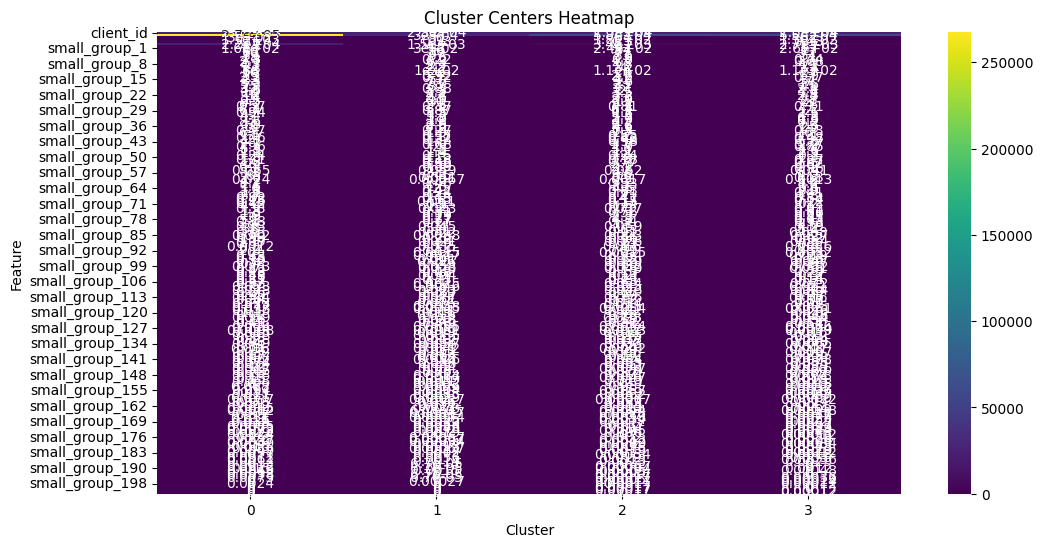

In [ ]:
# Compute the mean values of features for each cluster
cluster_centers = train.groupby('cluster').mean()

# Create a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_centers.T, annot=True, cmap='viridis')
plt.title('Cluster Centers Heatmap')
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.show()


### 2. Scatter Plot Matrix
Use sns.scatterplot for selected feature pairs:

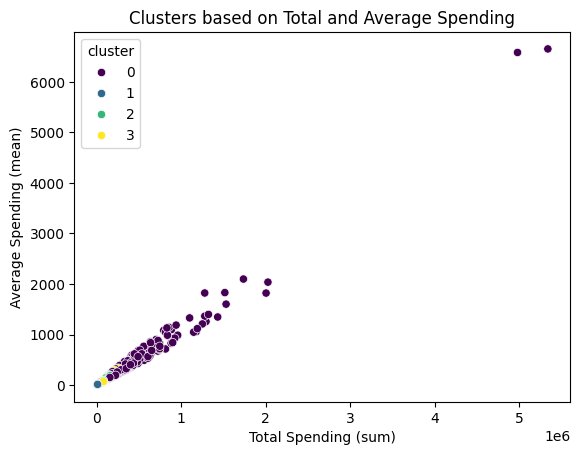

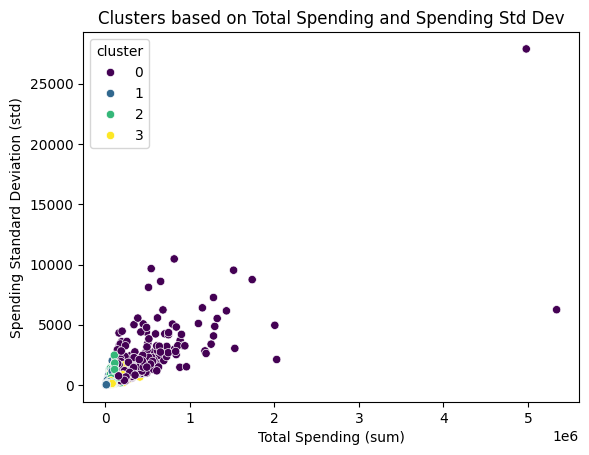

In [ ]:
features = ['sum', 'mean', 'std']
sns.scatterplot(x=train['sum'], y=train['mean'], hue=train['cluster'], palette='viridis')
plt.xlabel('Total Spending (sum)')
plt.ylabel('Average Spending (mean)')
plt.title('Clusters based on Total and Average Spending')
plt.show()

sns.scatterplot(x=train['sum'], y=train['std'], hue=train['cluster'], palette='viridis')
plt.xlabel('Total Spending (sum)')
plt.ylabel('Spending Standard Deviation (std)')
plt.title('Clusters based on Total Spending and Spending Std Dev')
plt.show()

### 3. Distribution Plots for Each Feature
Use sns.histplot or sns.kdeplot to show the distribution of each feature per cluster:

<ipython-input-38-6b79b7aa763c>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset[feature], label=f'Cluster {cluster}', shade=True)
<ipython-input-38-6b79b7aa763c>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset[feature], label=f'Cluster {cluster}', shade=True)
<ipython-input-38-6b79b7aa763c>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset[feature], label=f'Cluster {cluster}', shade=True)
<ipython-input-38-6b79b7aa763c>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset[fe

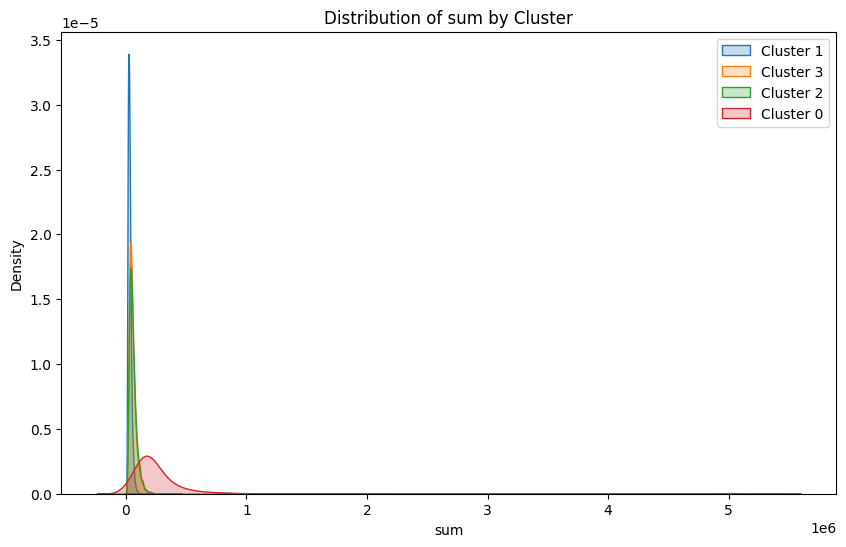

<ipython-input-38-6b79b7aa763c>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset[feature], label=f'Cluster {cluster}', shade=True)
<ipython-input-38-6b79b7aa763c>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset[feature], label=f'Cluster {cluster}', shade=True)
<ipython-input-38-6b79b7aa763c>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset[feature], label=f'Cluster {cluster}', shade=True)
<ipython-input-38-6b79b7aa763c>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset[fe

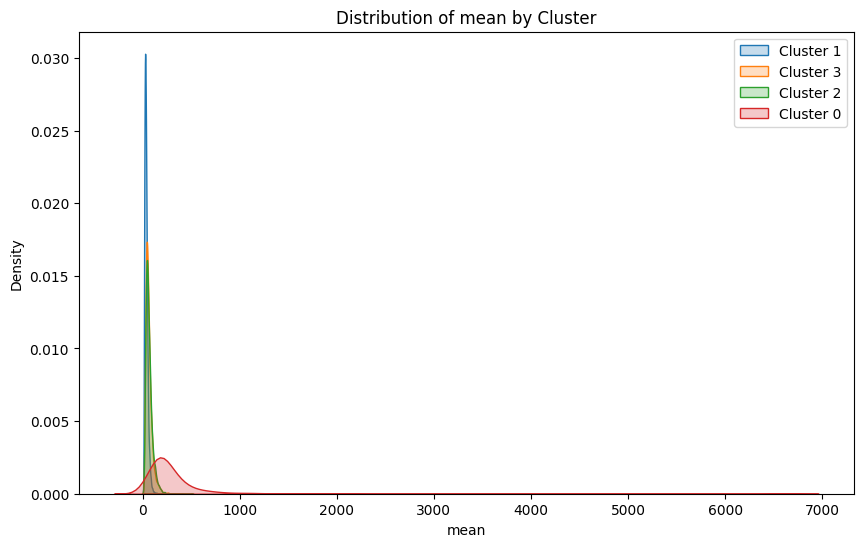

<ipython-input-38-6b79b7aa763c>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset[feature], label=f'Cluster {cluster}', shade=True)
<ipython-input-38-6b79b7aa763c>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset[feature], label=f'Cluster {cluster}', shade=True)
<ipython-input-38-6b79b7aa763c>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset[feature], label=f'Cluster {cluster}', shade=True)
<ipython-input-38-6b79b7aa763c>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset[fe

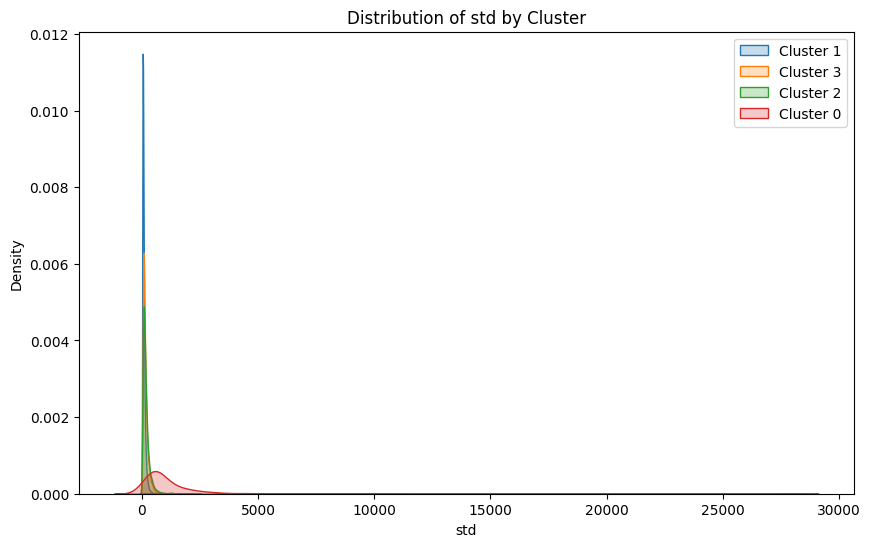

In [ ]:
# Plot distribution of features for each cluster
features = ['sum', 'mean', 'std']
for feature in features:
    plt.figure(figsize=(10, 6))
    for cluster in train['cluster'].unique():
        subset = train[train['cluster'] == cluster]
        sns.kdeplot(subset[feature], label=f'Cluster {cluster}', shade=True)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()


In [ ]:
cd /content/drive/MyDrive/Colab-Notebooks/Data-Science/baseline

/content/drive/MyDrive/Colab-Notebooks/Data-Science/baseline


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


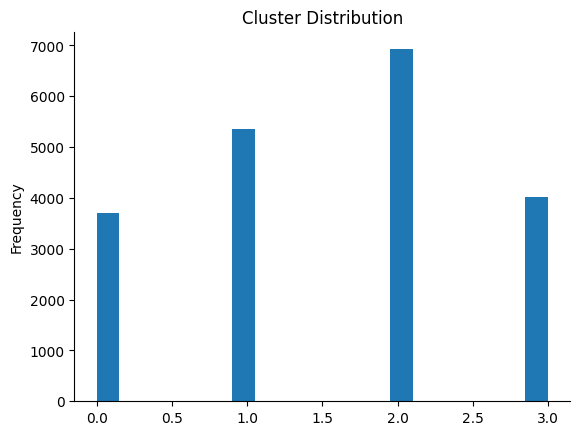

In [15]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.semi_supervised import LabelSpreading
import joblib  # For saving and loading models
from matplotlib import pyplot as plt

# Load datasets
data_path = '/content/drive/MyDrive/Colab-Notebooks/Data-Science/baseline/dataset/'
transactions_train = pd.read_csv(data_path + 'transactions_train.csv')
train_target = pd.read_csv(data_path + 'train_target.csv')
transactions_test = pd.read_csv(data_path + 'transactions_test.csv')
test_id = pd.read_csv(data_path + 'test.csv')

# Calculate aggregation features for each client
agg_features_train = transactions_train.groupby('client_id')['amount_rur'].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
agg_features_test = transactions_test.groupby('client_id')['amount_rur'].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()

# Calculate transaction counts for each category for each client
counter_df_train = transactions_train.groupby(['client_id', 'small_group'])['amount_rur'].count()
cat_counts_train = counter_df_train.reset_index().pivot(index='client_id', columns='small_group', values='amount_rur').fillna(0)
cat_counts_train.columns = ['small_group_' + str(i) for i in cat_counts_train.columns]

counter_df_test = transactions_test.groupby(['client_id', 'small_group'])['amount_rur'].count()
cat_counts_test = counter_df_test.reset_index().pivot(index='client_id', columns='small_group', values='amount_rur').fillna(0)
cat_counts_test.columns = ['small_group_' + str(i) for i in cat_counts_test.columns]

# Merge train data
train = pd.merge(train_target, agg_features_train, on='client_id')
train = pd.merge(train, cat_counts_train.reset_index(), on='client_id')

# Merge test data
test = pd.merge(test_id, agg_features_test, on='client_id')
test = pd.merge(test, cat_counts_test.reset_index(), on='client_id')
common_features = list(set(train.columns).intersection(set(test.columns)))
y_train = train['bins']
X_train = train[common_features]
X_test = test[common_features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.drop(columns=['client_id']))
X_test_scaled = scaler.transform(X_test.drop(columns=['client_id']))

# Model file path
model_file = 'label_prop_model.pkl'

# Check if the model file exists
if os.path.exists(model_file):
    # Load the model from the file
    label_prop_model = joblib.load(model_file)
else:
    # Semi-supervised clustering using Label Spreading with batch processing
    batch_size = 1000
    num_batches = len(X_train_scaled) // batch_size

    label_prop_model = LabelSpreading(kernel='rbf', gamma=0.25)

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(X_train_scaled))
        batch_X = X_train_scaled[start_idx:end_idx]
        batch_y = train_target['bins'].iloc[start_idx:end_idx]
        label_prop_model.fit(batch_X, batch_y)

    # Save the model to the file
    joblib.dump(label_prop_model, model_file)

# Predict test clusters
test_clusters = label_prop_model.predict(X_test_scaled)

# Prepare submission file
submission = pd.DataFrame({'client_id': test['client_id'], 'cluster': test_clusters})
submission['cluster'].plot(kind='hist', bins=20, title='Cluster Distribution')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


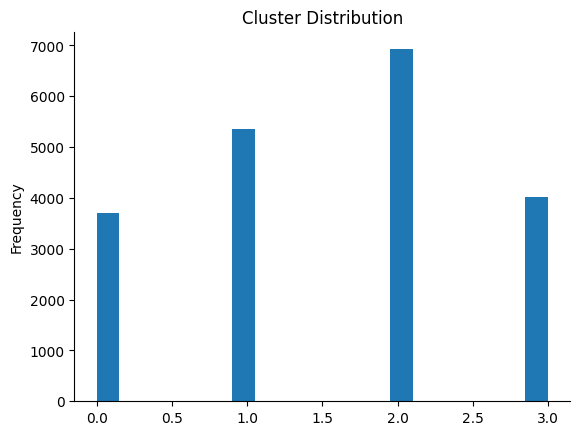

In [ ]:
import os
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.semi_supervised import LabelSpreading
from matplotlib import pyplot as plt

# Set your data path where scaler.pkl and label_prop_model.pkl are saved
data_path = '/content/drive/MyDrive/Colab-Notebooks/Data-Science/baseline/dataset/'

# Load the test dataset
transactions_test_path = '/content/drive/MyDrive/Colab-Notebooks/Data-Science/baseline/dataset/transactions_test.csv'
test_id_path = '/content/drive/MyDrive/Colab-Notebooks/Data-Science/baseline/dataset/test.csv'

transactions_test = pd.read_csv(transactions_test_path)
test_id = pd.read_csv(test_id_path)

# Calculate aggregation features for each client in test data
agg_features_test = transactions_test.groupby('client_id')['amount_rur'].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()

# Calculate transaction counts for each category for each client in test data
counter_df_test = transactions_test.groupby(['client_id', 'small_group'])['amount_rur'].count()
cat_counts_test = counter_df_test.reset_index().pivot(index='client_id', columns='small_group', values='amount_rur').fillna(0)
cat_counts_test.columns = ['small_group_' + str(i) for i in cat_counts_test.columns]

# Merge test data
test = pd.merge(test_id, agg_features_test, on='client_id')
test = pd.merge(test, cat_counts_test.reset_index(), on='client_id')
common_features = list(set(test.columns).intersection(set(train.columns)))  # Assuming common features with training data
X_test = test[common_features]

# Load the scaler
scaler_file = os.path.join(data_path, 'scaler.pkl')
scaler = joblib.load(scaler_file)

# Scale the test data
X_test_scaled = scaler.transform(X_test.drop(columns=['client_id']))

# Load the Label Spreading model
model_file = os.path.join(data_path, 'label_prop_model.pkl')
label_prop_model = joblib.load(model_file)

# Predict test clusters
test_clusters = label_prop_model.predict(X_test_scaled)

# Prepare submission file or visualization (if needed)
submission = pd.DataFrame({'client_id': test['client_id'], 'cluster': test_clusters})
submission['cluster'].plot(kind='hist', bins=20, title='Cluster Distribution')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()


In [14]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.semi_supervised import LabelSpreading
import joblib
from matplotlib import pyplot as plt

# Load datasets
data_path = '/content/drive/MyDrive/Colab-Notebooks/Data-Science/baseline/dataset/'
transactions_train = pd.read_csv(data_path + 'transactions_train.csv')
train_target = pd.read_csv(data_path + 'train_target.csv')
transactions_test = pd.read_csv(data_path + 'transactions_test.csv')
test_id = pd.read_csv(data_path + 'test.csv')

# Calculate aggregation features for each client
agg_features_train = transactions_train.groupby('client_id')['amount_rur'].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
agg_features_test = transactions_test.groupby('client_id')['amount_rur'].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()

# Calculate transaction counts for each category for each client
counter_df_train = transactions_train.groupby(['client_id', 'small_group'])['amount_rur'].count()
cat_counts_train = counter_df_train.reset_index().pivot(index='client_id', columns='small_group', values='amount_rur').fillna(0)
cat_counts_train.columns = ['small_group_' + str(i) for i in cat_counts_train.columns]

counter_df_test = transactions_test.groupby(['client_id', 'small_group'])['amount_rur'].count()
cat_counts_test = counter_df_test.reset_index().pivot(index='client_id', columns='small_group', values='amount_rur').fillna(0)
cat_counts_test.columns = ['small_group_' + str(i) for i in cat_counts_test.columns]

# Merge train data
train = pd.merge(train_target, agg_features_train, on='client_id')
train = pd.merge(train, cat_counts_train.reset_index(), on='client_id')

# Merge test data
test = pd.merge(test_id, agg_features_test, on='client_id')
test = pd.merge(test, cat_counts_test.reset_index(), on='client_id')

# Identify common features
common_features = list(set(train.columns).intersection(set(test.columns)))

# Split features and target variable
y_train = train['bins']
X_train = train[common_features]
X_test = test[common_features]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.drop(columns=['client_id']))
X_test_scaled = scaler.transform(X_test.drop(columns=['client_id']))

# Model file path
model_file = 'label_prop_model.pkl'

# Check if the model file exists
if os.path.exists(model_file):
    # Load the model from the file
    label_prop_model = joblib.load(model_file)
else:
    # Semi-supervised clustering using Label Spreading
    label_prop_model = LabelSpreading(kernel='rbf', gamma=0.25)

    # Fit the model in batches
    batch_size = 1000
    num_batches = (len(X_train_scaled) // batch_size) + 1

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(X_train_scaled))
        batch_X = X_train_scaled[start_idx:end_idx]
        batch_y = y_train.iloc[start_idx:end_idx]
        label_prop_model.fit(batch_X, batch_y)

    # Save the model to the file
    joblib.dump(label_prop_model, model_file)

# Predict test clusters
test_clusters = label_prop_model.predict(X_test_scaled)

# Prepare submission file
submission = pd.DataFrame({'client_id': test['client_id'], 'cluster': test_clusters})

# Plot cluster distribution
submission['cluster'].plot(kind='hist', bins=20, title='Cluster Distribution')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

ValueError: Found array with 0 sample(s) (shape=(0, 192)) while a minimum of 1 is required by LabelSpreading.